In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch_geometric.transforms as T

import fish_models
#import robofish.io

from SwarmNet import create_swarm_dataset, train_SwarmNet, save_model, load_model, Pose_and_View_SwarmNet, CouzinModel, Edgeweight_SwarmNet

In [2]:
import pandas as pd

# Data

In [2]:
#fish_models.raw_data("pascal_6fish_couzin") 

Downlaoding Data from https://userpage.fu-berlin.de/andigerken/model_server/raw_data/pascal_6fish_couzin.zip and extracting it to c:\users\olaf\onedrive\öffentlich\master\researchinternship\fish_models\storage\raw_data\pascal_6fish_couzin.


WindowsPath('c:/users/olaf/onedrive/öffentlich/master/researchinternship/fish_models/storage/raw_data/pascal_6fish_couzin')

In [3]:
raycast = fish_models.Raycast(
            n_fish_bins=150,
            n_wall_raycasts=150,
            fov_angle_fish_bins=2*np.pi,
            fov_angle_wall_raycasts=2*np.pi,
            world_bounds=([-50, -50], [50, 50]),
            view_of = ["fish", "fish_oris", "walls"]
        )

In [4]:
BATCH_SIZE = 320

# data_folder = r"c:\users\olaf\onedrive\öffentlich\master\researchinternship\fish_models\storage\raw_data\pascal_6fish_couzin\train"
# dset = fish_models.IoDataset(data_folder, raycast, output_strings=["poses", "actions", "views"], max_files=800)
# train_loader = create_swarm_dataset(dset["poses"], dset["actions"], dset["views"], batchsize=BATCH_SIZE, filter_distance=None)
# train_loader_filter = create_swarm_dataset(dset["poses"], dset["actions"], dset["views"], batchsize=BATCH_SIZE, filter_distance=40)
# train_loader_nograph = create_swarm_dataset(dset["poses"], dset["actions"], dset["views"], batchsize=BATCH_SIZE, filter_distance=0)
# del dset
data_folder = r"c:\users\olaf\onedrive\öffentlich\master\researchinternship\fish_models\storage\raw_data\pascal_6fish_couzin\test"
dset_test = fish_models.IoDataset(data_folder,raycast,output_strings=["poses", "actions", "views"],max_files=100)
test_loader = create_swarm_dataset(dset_test["poses"], dset_test["actions"], dset_test["views"], batchsize=BATCH_SIZE, filter_distance=None)
test_loader_filter = create_swarm_dataset(dset_test["poses"], dset_test["actions"], dset_test["views"], batchsize=BATCH_SIZE, filter_distance=40)
test_loader_nograph = create_swarm_dataset(dset_test["poses"], dset_test["actions"], dset_test["views"], batchsize=BATCH_SIZE, filter_distance=0)
del dset_test
data_folder = r"c:\users\olaf\onedrive\öffentlich\master\researchinternship\fish_models\storage\raw_data\pascal_6fish_couzin\validation"
dset_val = fish_models.IoDataset(data_folder,raycast,output_strings=["poses", "actions", "views"],max_files=100)
val_loader = create_swarm_dataset(dset_val["poses"], dset_val["actions"], dset_val["views"], batchsize=BATCH_SIZE, filter_distance=None)
val_loader_filter = create_swarm_dataset(dset_val["poses"], dset_val["actions"], dset_val["views"], batchsize=BATCH_SIZE, filter_distance=40)
val_loader_nograph = create_swarm_dataset(dset_val["poses"], dset_val["actions"], dset_val["views"], batchsize=BATCH_SIZE, filter_distance=0)
del dset_val

Loading data from 100 files.


100%|████████████████████████████████████████| 100/100 [00:04<00:00, 21.77it/s]


None
Calculating views from 100 files.


100%|████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]


Reducing shape of poses.


100%|█████████████████████████████████████| 100/100 [00:00<00:00, 50009.59it/s]


Reducing shape of actions.


100%|█████████████████████████████████████| 100/100 [00:00<00:00, 50039.42it/s]


Reducing shape of views.


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 2041.90it/s]


Status of IoDataset:
poses	(100, 6, 199, 3):	consisting of x, y, orientation.
actions	(100, 6, 199, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(100, 6, 199, 450):	consisting of 150 fish bins, 150 fish oris and 150 wall raycasts.

Loading data from 100 files.


100%|████████████████████████████████████████| 100/100 [00:04<00:00, 22.41it/s]


None
Calculating views from 100 files.


100%|████████████████████████████████████████| 100/100 [00:52<00:00,  1.91it/s]


Reducing shape of poses.


100%|█████████████████████████████████████| 100/100 [00:00<00:00, 25013.74it/s]


Reducing shape of actions.


100%|█████████████████████████████████████| 100/100 [00:00<00:00, 50027.48it/s]


Reducing shape of views.


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 2632.91it/s]


Status of IoDataset:
poses	(100, 6, 199, 3):	consisting of x, y, orientation.
actions	(100, 6, 199, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(100, 6, 199, 450):	consisting of 150 fish bins, 150 fish oris and 150 wall raycasts.



# Training with different number of layers

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
train_loss_list, val_loss_list = [], []
for n_linears in range(1, 11):
    PATH = f"pascal6_model_{n_linears}_layer.pt"
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=n_linears).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader, val_loader,
                                                      criterion, epochs=50, device=device)
    save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)
    print(f"fully: {n_linears} linear layer: train loss: {train_losses[-1]:.3f}, val loss: {val_losses[-1]:.3f}")
    train_loss_list.append(train_losses)
    val_loss_list.append(val_losses)
    
    PATH = f"pascal6_model_{n_linears}_layer_filtered.pt"
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=n_linears).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader_filter, val_loader_filter,
                                                      criterion, epochs=50, device=device)
    save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)
    print(f"filter: {n_linears} linear layer: train loss: {train_losses[-1]:.3f}, val loss: {val_losses[-1]:.3f}")
    train_loss_list.append(train_losses)
    val_loss_list.append(val_losses)

[Train: 0.333][Val: 0.335]: 100%|██████████████| 50/50 [27:50<00:00, 33.40s/it]


fully: 1 linear layer: train loss: 0.333, val loss: 0.335


[Train: 0.328][Val: 0.333]: 100%|██████████████| 50/50 [32:15<00:00, 38.71s/it]


filter: 1 linear layer: train loss: 0.328, val loss: 0.333


[Train: 0.325][Val: 0.330]: 100%|██████████████| 50/50 [25:46<00:00, 30.94s/it]


fully: 2 linear layer: train loss: 0.325, val loss: 0.330


[Train: 0.318][Val: 0.323]: 100%|██████████████| 50/50 [30:27<00:00, 36.56s/it]


filter: 2 linear layer: train loss: 0.318, val loss: 0.323


[Train: 0.322][Val: 0.326]: 100%|██████████████| 50/50 [28:54<00:00, 34.70s/it]


fully: 3 linear layer: train loss: 0.322, val loss: 0.326


[Train: 0.314][Val: 0.321]: 100%|██████████████| 50/50 [28:47<00:00, 34.56s/it]


filter: 3 linear layer: train loss: 0.314, val loss: 0.321


[Train: 0.321][Val: 0.331]: 100%|██████████████| 50/50 [28:45<00:00, 34.50s/it]


fully: 4 linear layer: train loss: 0.321, val loss: 0.331


[Train: 0.313][Val: 0.320]: 100%|██████████████| 50/50 [31:04<00:00, 37.30s/it]


filter: 4 linear layer: train loss: 0.313, val loss: 0.320


[Train: 0.320][Val: 0.339]: 100%|██████████████| 50/50 [30:42<00:00, 36.84s/it]


fully: 5 linear layer: train loss: 0.320, val loss: 0.339


[Train: 0.313][Val: 0.317]: 100%|██████████████| 50/50 [34:32<00:00, 41.44s/it]


filter: 5 linear layer: train loss: 0.313, val loss: 0.317


[Train: 0.320][Val: 0.336]: 100%|██████████████| 50/50 [32:20<00:00, 38.82s/it]


fully: 6 linear layer: train loss: 0.320, val loss: 0.336


[Train: 0.311][Val: 0.324]: 100%|██████████████| 50/50 [30:23<00:00, 36.48s/it]


filter: 6 linear layer: train loss: 0.311, val loss: 0.324


[Train: 0.320][Val: 0.331]: 100%|██████████████| 50/50 [33:11<00:00, 39.82s/it]


fully: 7 linear layer: train loss: 0.320, val loss: 0.331


[Train: 0.313][Val: 0.325]: 100%|██████████████| 50/50 [34:21<00:00, 41.23s/it]


filter: 7 linear layer: train loss: 0.313, val loss: 0.325


[Train: 0.297][Val: 0.301]: 100%|██████████████| 50/50 [34:53<00:00, 41.87s/it]


fully: 8 linear layer: train loss: 0.297, val loss: 0.301


[Train: 0.313][Val: 0.330]: 100%|██████████████| 50/50 [34:57<00:00, 41.95s/it]


filter: 8 linear layer: train loss: 0.313, val loss: 0.330


[Train: 0.322][Val: 0.329]: 100%|██████████████| 50/50 [35:40<00:00, 42.81s/it]


fully: 9 linear layer: train loss: 0.322, val loss: 0.329


[Train: 0.313][Val: 0.332]: 100%|██████████████| 50/50 [36:30<00:00, 43.81s/it]


filter: 9 linear layer: train loss: 0.313, val loss: 0.332


[Train: 0.320][Val: 0.335]: 100%|██████████████| 50/50 [36:16<00:00, 43.52s/it]


fully: 10 linear layer: train loss: 0.320, val loss: 0.335


[Train: 0.285][Val: 0.290]: 100%|██████████████| 50/50 [37:20<00:00, 44.82s/it]


filter: 10 linear layer: train loss: 0.285, val loss: 0.290


### Load Models again

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loss_list, val_loss_list = [], []
for n_linears in range(1, 11):
    PATH = f"pascal6_model_{n_linears}_layer.pt"
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=n_linears).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
    train_loss_list.append(prev_train_losses)
    val_loss_list.append(prev_val_losses)
    
    PATH = f"pascal6_model_{n_linears}_layer_filtered.pt"
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=n_linears).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
    train_loss_list.append(prev_train_losses)
    val_loss_list.append(prev_val_losses)

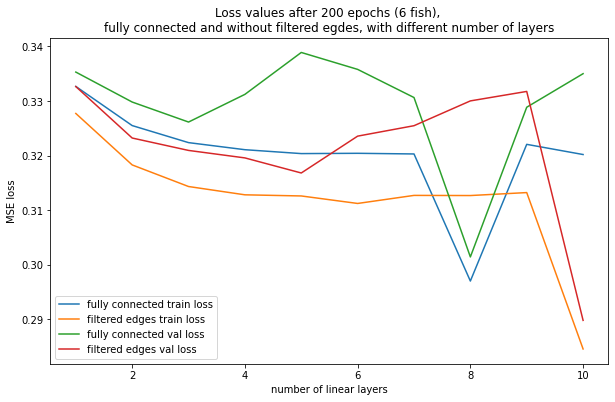

In [6]:
plt.figure(figsize=(10,6))
x = np.arange(1,11)
plt.plot(x,np.array(train_loss_list)[:, -1][::2], label="fully connected train loss")
plt.plot(x,np.array(train_loss_list)[:, -1][1::2], label="filtered edges train loss")
plt.plot(x,np.array(val_loss_list)[:, -1][::2], label="fully connected val loss")
plt.plot(x,np.array(val_loss_list)[:, -1][1::2], label="filtered edges val loss")
plt.legend()
plt.title("Loss values after 200 epochs (6 fish), \nfully connected and without filtered egdes, with different number of layers")
plt.xlabel("number of linear layers")
plt.ylabel("MSE loss")
plt.show()

# Edge Prediction

In [9]:
#from SwarmNet import Edgeweight_SwarmNet

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# criterion = nn.MSELoss()
# model = Edgeweight_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
#                                conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader, val_loader,
#                                                   criterion, epochs=500, device=device)


Epoch::   0%|                                          | 0/500 [00:22<?, ?it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\Anaconda3\envs\torch_fish_env\lib\site-packages\IPython\core\interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-107888c5fd6e>", line 6, in <module>
    train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader, val_loader,
  File "C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\SwarmNet.py", line 77, in train_SwarmNet
    pred_lbl = model(data.pose, data.view, data.edge_index)
  File "D:\Anaconda3\envs\torch_fish_env\lib\site-packages\torch\nn\modules\module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\SwarmNet.py", line 164, in forward
    views = self.lrelu(self.encoder1(views))
  File "D:\Anaconda3\envs\torch_fish_env\lib\site-packages\torch\nn\modules\module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



  File "D:\Anaconda3\envs\torch_fish_env\lib\site-packages\torch\nn\modules\conv.py", line 297, in _conv_forward
    return F.conv1d(input, weight, bias, self.stride,
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda3\envs\torch_fish_env\lib\site-packages\IPython\core\interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda3\envs\torch_fish_env\lib\site-packages\IPython\core\interactiveshell.py", line 3337, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "D:\Anaconda3\envs\torch_fish_env\lib\site-packages\IPython\core\interactiveshell.py", line 3434, in run_code
    self.showtraceback(running_compiled_code=True)
  File "D:\Anacond

In [8]:
# PATH = "pascal_edge_prediction.pth"
# save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)

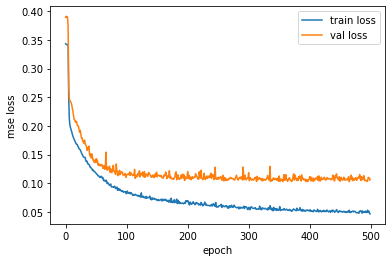

In [9]:
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.xlabel("epoch")
plt.ylabel("mse loss")
plt.legend()
plt.show()

In [53]:
# from importlib import reload
# import SwarmNet
# reload(SwarmNet)
# from SwarmNet import Edgeweight_SwarmNet

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PATH = "pascal6_variation_0_learned.pt"
model = Edgeweight_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                               conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)

In [12]:
prev_train_losses[-1], prev_val_losses[-1]

(0.26821731976438057, 0.280458872795105)

In [ ]:
# plot edge weights vs relative orientation (substract absolute orientations)
# plot jointplot with colours based on zone of orientation, ...
# fully connected, filtered, learned weights compare with same n_layers, multiple runs with mean, std
# compare to non-graph model of similar complexity, maybe only remove all edges

In [62]:
def normalize_series(x):
    """Normalize series.

    Given a series of vectors, return a series of normalized vectors.
    Null vectors are mapped to `NaN` vectors.
    """
    return (x.T / np.linalg.norm(x, axis=-1)).T

In [63]:
def calculate_follow(a, b):
    """Calculate the follow metric.

    Given two series of poses - with X and Y coordinates of their
    positions as the first two elements
    return the follow metric from the first to the second series.
    """
    a_v = a[1:, :2] - a[:-1, :2]
    b_p = normalize_series(b[:-1, :2] - a[:-1, :2])
    return (a_v * b_p).sum(axis=-1)

In [8]:
import scipy

In [65]:
positions = {x:[] for x in range(6)}
edge_w = {x:{y:[] for y in range(6)} for x in range(6)}
turn_dict = {x:[] for x in range(6)}
for variation in range(1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    PATH = f"variation_{variation}_learned.pt"
    model = Edgeweight_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            edge_weights = model.get_edge_weights(data.pose, data.view, data.edge_index)
            turns = model(data.pose, data.view, data.edge_index).flatten().cpu().detach().numpy()
            for i in range(6):
                positions[i].append(data.pose[i::6].cpu().detach().numpy())
                turn_dict[i].append(turns[i::6])
                for j in range(6):
                    if i != j:
                        edge_w[i][j].append(edge_weights[(torch.remainder(data.edge_index[0], 6) == i) & (torch.remainder(data.edge_index[1], 6) == j)].cpu().detach().numpy())
                        
positions = np.stack(list((np.concatenate(positions[key]).reshape((100,199,3)) for key in positions)))
turns = np.stack(list((np.concatenate(turn_dict[key]).reshape((100,199)) for key in turn_dict)))
edge_w = np.stack(list((np.stack(list((np.concatenate(edge_w[0][key2]).reshape((100,199)) if 0 != key2 else np.zeros((100,199)) for key2 in edge_w[0]))) for key in edge_w))).squeeze()
euclidean_points = []
turn_points = []
edge_w_points = []
edge_w_points2 = []
radiants_points = []
follow_points = []
timesteps = []
for i in range(6):
    for j in range(6):
        if i != j:
            for i_file in range(100):
                euclidean_points.append(np.diag(scipy.spatial.distance.cdist(positions[i, i_file, 1:, :2], positions[j, i_file, 1:, :2])))
                turn_points.append(turns[i, i_file, 1:])
                edge_w_points.append(edge_w[i, j, i_file, 1:])
                edge_w_points2.append(edge_w[j, i, i_file, 1:])
                radiants_points.append(np.diag(scipy.spatial.distance.cdist(positions[i, i_file, 1:, 2:], positions[j, i_file, 1:, 2:])))
                follow_points.append(calculate_follow(positions[i, i_file, :, :2], positions[j, i_file, :, :2]))
                timesteps.append(np.arange(1,199))
euclidean_points = np.concatenate(euclidean_points)
turn_points = np.concatenate(turn_points)
edge_w_points = np.concatenate(edge_w_points)
edge_w_points2 = np.concatenate(edge_w_points2)
radiants_points = np.concatenate(radiants_points)
radiants_points_pi = np.where(radiants_points > np.pi, -radiants_points, radiants_points) % np.pi
follow_points = np.concatenate(follow_points)
timesteps = np.concatenate(timesteps)

In [66]:
euclidean_points.shape, turn_points.shape, edge_w_points.shape, radiants_points.shape, follow_points.shape

((594000,), (594000,), (594000,), (594000,), (594000,))

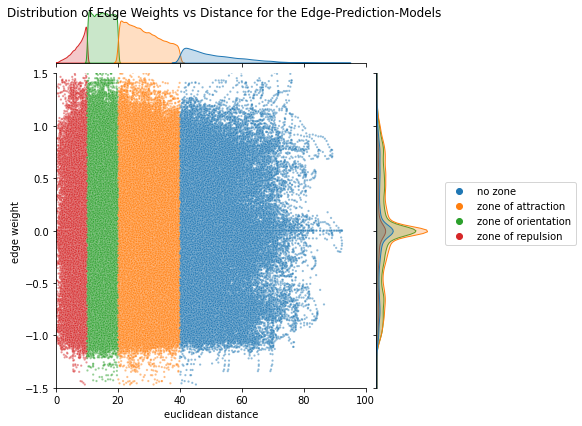

In [11]:
df = pd.DataFrame({
    'euclidean distance': euclidean_points,
    'edge weight': edge_w_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
p = sns.jointplot(data=df, y="edge weight", x="euclidean distance", s=5, hue="zone", alpha=0.5)
p.fig.suptitle("Distribution of Edge Weights vs Distance for the Edge-Prediction-Models")
p.fig.get_axes()[0].legend().set_visible(False)
p.fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
p.ax_marg_y.set_ylim(-1.5,1.5)
p.ax_marg_x.set_xlim(0,100)
plt.show()

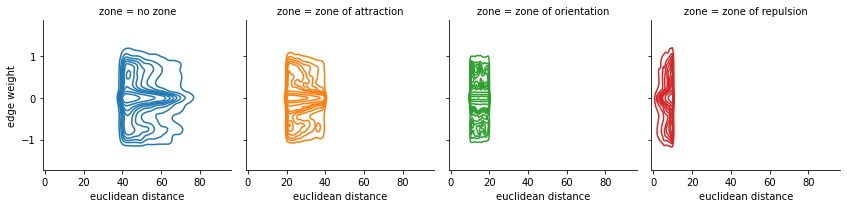

In [159]:
df = pd.DataFrame({
    'euclidean distance': euclidean_points,
    'edge weight': edge_w_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
g = sns.FacetGrid(df, col="zone", hue="zone", margin_titles=True)
g.map_dataframe(sns.kdeplot, x="euclidean distance", y="edge weight")
p.fig.suptitle("Distribution of Edge Weights vs Distance for the Edge-Prediction-Models")
plt.show()

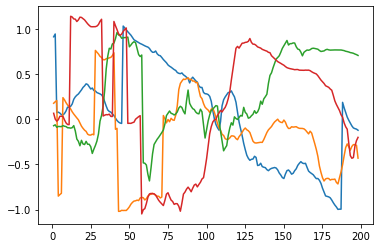

In [15]:
plt.plot(timesteps[:198], edge_w_points[:198])
plt.plot(timesteps[198:2*198], edge_w_points[198:2*198])
plt.plot(timesteps[2*198:3*198], edge_w_points[2*198:3*198])
plt.plot(timesteps[3*198:4*198], edge_w_points[3*198:4*198])

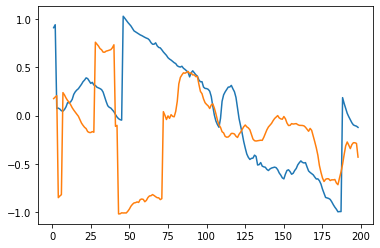

In [78]:
plt.plot(np.swapaxes(timesteps.reshape((-1,198))[:2,:],0,1), np.swapaxes(edge_w_points.reshape((-1,198))[:2,:],0,1))

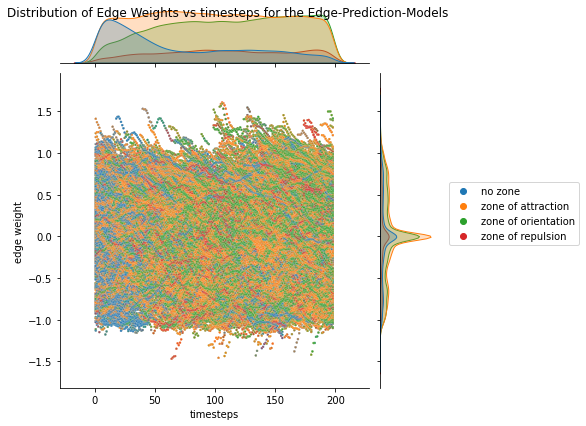

In [17]:
df = pd.DataFrame({
    'timesteps': timesteps,
    'edge weight': edge_w_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
p = sns.jointplot(data=df, y="edge weight", x="timesteps", s=5, hue="zone", alpha=0.5)
p.fig.suptitle("Distribution of Edge Weights vs timesteps for the Edge-Prediction-Models")
p.fig.get_axes()[0].legend().set_visible(False)
p.fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# p.ax_marg_y.set_ylim(-1.5,1.5)
# p.ax_marg_x.set_xlim(0,200)
plt.show()

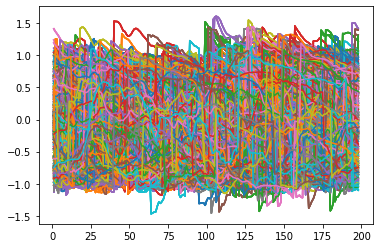

In [79]:
plt.plot(np.swapaxes(timesteps.reshape((-1,198)),0,1), np.swapaxes(edge_w_points.reshape((-1,198)),0,1))
plt.show()

In [80]:
timesteps.reshape((-1,198)).shape

(3000, 198)

In [81]:
euclidean_points.reshape((-1,198)).shape

(3000, 198)

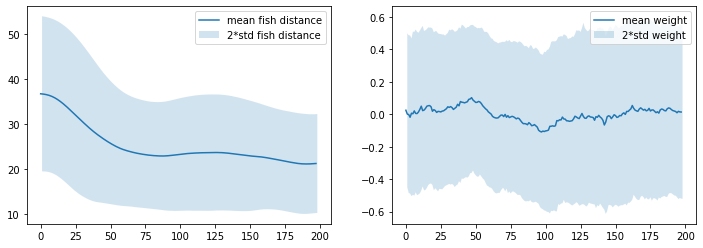

In [82]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
a = np.mean(euclidean_points.reshape((-1,198)), axis=0)
b = np.std(euclidean_points.reshape((-1,198)), axis=-0)
c = timesteps.reshape((-1,198))
axs[0].plot(a, label=f"mean fish distance")
axs[0].fill_between(c[0], a - b, a + b, alpha=0.2, label=f"2*std fish distance")
a = np.mean(edge_w_points.reshape((-1,198)), axis=0)
b = np.std(edge_w_points.reshape((-1,198)), axis=0)
axs[1].plot(a, label=f"mean weight")
axs[1].fill_between(c[0], a - b, a + b, alpha=0.2, label=f"2*std weight")
axs[0].legend()
axs[1].legend()
plt.show()

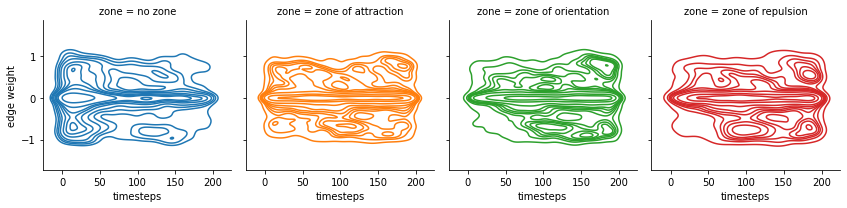

In [58]:
df = pd.DataFrame({
    'timesteps': timesteps,
    'edge weight': edge_w_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
g = sns.FacetGrid(df, col="zone", hue="zone", margin_titles=True)
g.map_dataframe(sns.kdeplot, x="timesteps", y="edge weight")
p.fig.suptitle("Distribution of Edge Weights vs timesteps for the Edge-Prediction-Models")
plt.show()

D:\Anaconda3\envs\torch_fish_env\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


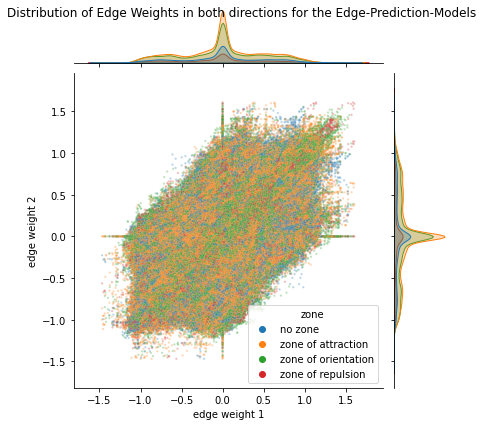

In [161]:
df = pd.DataFrame({
    'edge weight 1': edge_w_points,
    'edge weight 2': edge_w_points2,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
p = sns.jointplot(data=df, x="edge weight 1", y="edge weight 2", s=5, hue="zone", alpha=0.3)
p.fig.suptitle("Distribution of Edge Weights in both directions for the Edge-Prediction-Models")
# p.fig.get_axes()[0].legend().set_visible(False)
# p.fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# p.ax_marg_y.set_ylim(-1.5,1.5)
# p.ax_marg_x.set_xlim(-1.5,1.5)
plt.show()

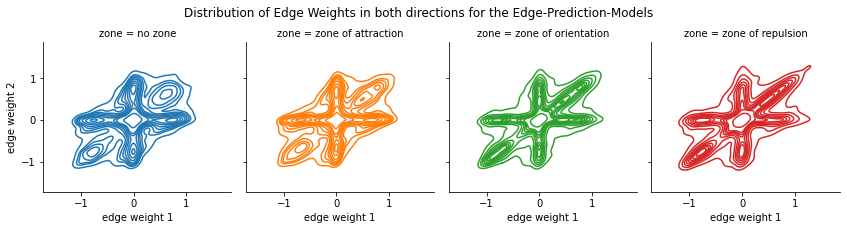

In [162]:
df = pd.DataFrame({
    'edge weight 1': edge_w_points,
    'edge weight 2': edge_w_points2,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
g = sns.FacetGrid(df, col="zone", hue="zone", margin_titles=True)
g.map_dataframe(sns.kdeplot, x="edge weight 1", y="edge weight 2")
#g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of Edge Weights in both directions for the Edge-Prediction-Models", y=1.05)
plt.show()
# g.set_axis_labels("Total bill ($)", "Tip ($)")
# g.set_titles(col_template="{col_name} patrons", row_template="{row_name}")
# g.set(xlim=(0, 60), ylim=(0, 12), xticks=[10, 30, 50], yticks=[2, 6, 10])

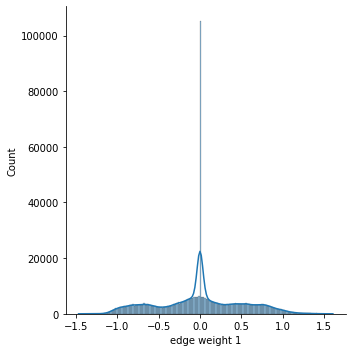

In [16]:
df = pd.DataFrame({
    'edge weight 1': edge_w_points,
    'edge weight 2': edge_w_points2,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
sns.displot(data=df, x="edge weight 1", kde=True)

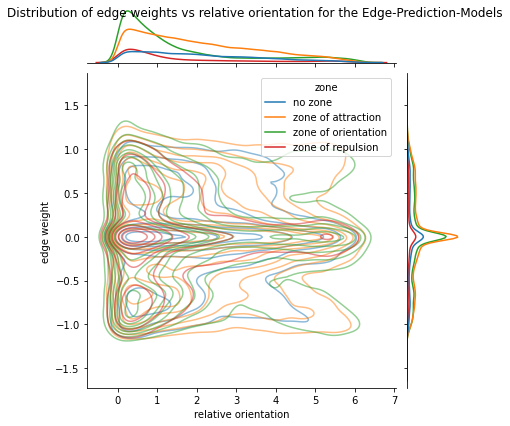

In [163]:
df = pd.DataFrame({
    'relative orientation': radiants_points,
    'edge weight': edge_w_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
p = sns.jointplot(data=df, y="edge weight", x="relative orientation", kind='kde', hue="zone", alpha=0.5)
p.fig.suptitle("Distribution of edge weights vs relative orientation for the Edge-Prediction-Models")
# p.fig.get_axes()[0].legend().set_visible(False)
# p.fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# p.ax_marg_y.set_ylim(-1.5,1.5)
# p.ax_marg_x.set_xlim(-0.5,7)
plt.show()

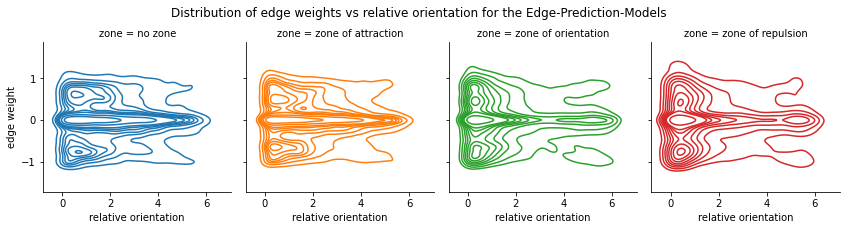

In [164]:
df = pd.DataFrame({
    'relative orientation': radiants_points,
    'edge weight': edge_w_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})

g = sns.FacetGrid(df, col="zone", hue='zone', margin_titles=True)
g.map_dataframe(sns.kdeplot, x="relative orientation", y="edge weight")
# g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of edge weights vs relative orientation for the Edge-Prediction-Models", y=1.05)
plt.show()
# g.set_axis_labels("Total bill ($)", "Tip ($)")
# g.set_titles(col_template="{col_name} patrons", row_template="{row_name}")
# g.set(xlim=(0, 60), ylim=(0, 12), xticks=[10, 30, 50], yticks=[2, 6, 10])

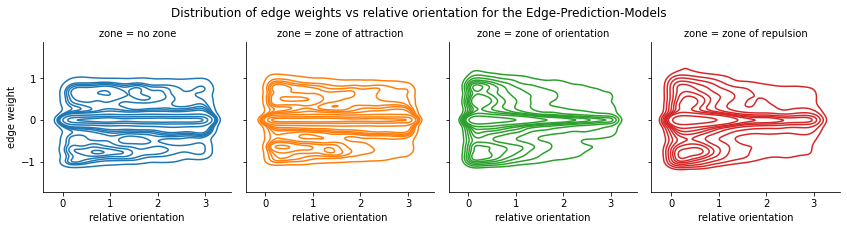

In [11]:
df = pd.DataFrame({
    'relative orientation': radiants_points_pi,
    'edge weight': edge_w_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})

g = sns.FacetGrid(df, col="zone", hue='zone', margin_titles=True)
g.map_dataframe(sns.kdeplot, x="relative orientation", y="edge weight")
# g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of edge weights vs relative orientation for the Edge-Prediction-Models", y=1.05)
plt.show()
# g.set_axis_labels("Total bill ($)", "Tip ($)")
# g.set_titles(col_template="{col_name} patrons", row_template="{row_name}")
# g.set(xlim=(0, 60), ylim=(0, 12), xticks=[10, 30, 50], yticks=[2, 6, 10])

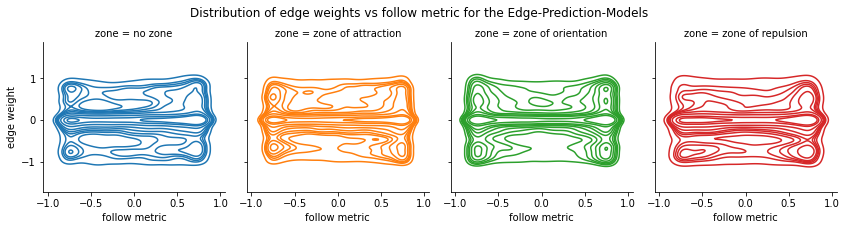

In [165]:
df = pd.DataFrame({
    'follow metric': follow_points,
    'edge weight': edge_w_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})

g = sns.FacetGrid(df, col="zone", hue='zone', margin_titles=True)
g.map_dataframe(sns.kdeplot, x="follow metric", y="edge weight")
# g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of edge weights vs follow metric for the Edge-Prediction-Models", y=1.05)
plt.show()
# g.set_axis_labels("Total bill ($)", "Tip ($)")
# g.set_titles(col_template="{col_name} patrons", row_template="{row_name}")
# g.set(xlim=(0, 60), ylim=(0, 12), xticks=[10, 30, 50], yticks=[2, 6, 10])

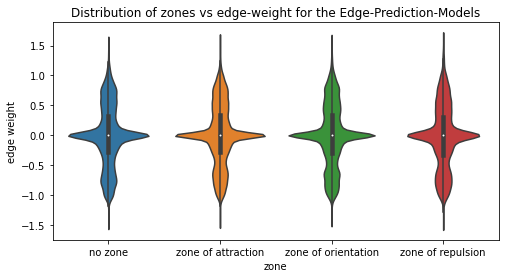

In [166]:
df = pd.DataFrame({
    'relative orientation': radiants_points,
    'edge weight': edge_w_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
plt.figure(figsize=(8,4))
p = sns.violinplot(data=df, x='zone', y="edge weight")
plt.title("Distribution of zones vs edge-weight for the Edge-Prediction-Models")
# p.fig.get_axes()[0].legend().set_visible(False)
# p.fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# p.ax_marg_y.set_ylim(-0.5,7)
# p.ax_marg_x.set_xlim(-10,100)
plt.show()

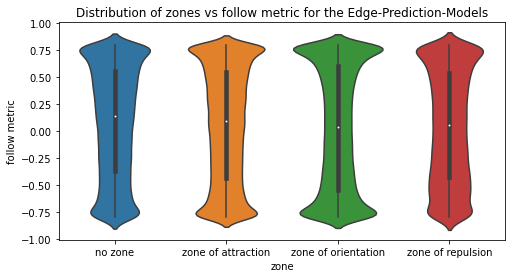

In [193]:
df = pd.DataFrame({
    'follow metric': follow_points,
    'edge weight': edge_w_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
plt.figure(figsize=(8,4))
p = sns.violinplot(data=df, x='zone', y="follow metric")
plt.title("Distribution of zones vs follow metric for the Edge-Prediction-Models")
# p.fig.get_axes()[0].legend().set_visible(False)
# p.fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# p.ax_marg_y.set_ylim(-0.5,7)
# p.ax_marg_x.set_xlim(-10,100)
plt.show()

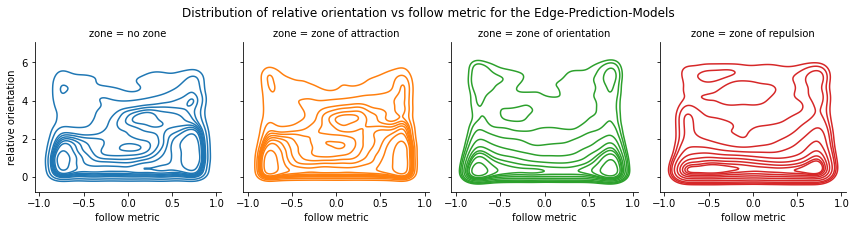

In [195]:
df = pd.DataFrame({
    'follow metric': follow_points,
    'relative orientation': radiants_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})

g = sns.FacetGrid(df, col="zone", hue='zone', margin_titles=True)
g.map_dataframe(sns.kdeplot, x="follow metric", y="relative orientation")
# g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of relative orientation vs follow metric for the Edge-Prediction-Models", y=1.05)
plt.show()
# g.set_axis_labels("Total bill ($)", "Tip ($)")
# g.set_titles(col_template="{col_name} patrons", row_template="{row_name}")
# g.set(xlim=(0, 60), ylim=(0, 12), xticks=[10, 30, 50], yticks=[2, 6, 10])

D:\Anaconda3\envs\torch_fish_env\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


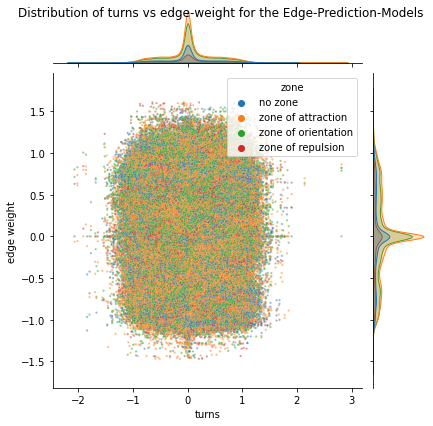

In [167]:
df = pd.DataFrame({
    'turns': turn_points,
    'edge weight': edge_w_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
p = sns.jointplot(data=df, y="edge weight", x="turns", s=5, hue="zone", alpha=0.5)
p.fig.suptitle("Distribution of turns vs edge-weight for the Edge-Prediction-Models")
# p.fig.get_axes()[0].legend().set_visible(False)
# p.fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# p.ax_marg_y.set_ylim(-0.5,7)
# p.ax_marg_x.set_xlim(-10,100)
plt.show()

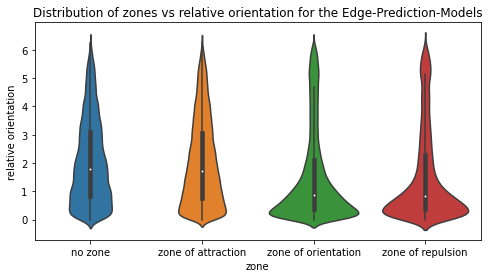

In [168]:
df = pd.DataFrame({
    'relative orientation': radiants_points,
    'euclidean distance': euclidean_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
plt.figure(figsize=(8,4))
p = sns.violinplot(data=df, x='zone', y="relative orientation")
plt.title("Distribution of zones vs relative orientation for the Edge-Prediction-Models")
# p.fig.get_axes()[0].legend().set_visible(False)
# p.fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# p.ax_marg_y.set_ylim(-0.5,7)
# p.ax_marg_x.set_xlim(-10,100)
plt.show()

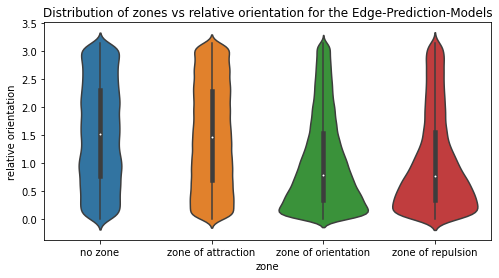

In [12]:
df = pd.DataFrame({
    'relative orientation': radiants_points_pi,
    'euclidean distance': euclidean_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
plt.figure(figsize=(8,4))
p = sns.violinplot(data=df, x='zone', y="relative orientation")
plt.title("Distribution of zones vs relative orientation for the Edge-Prediction-Models")
# p.fig.get_axes()[0].legend().set_visible(False)
# p.fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# p.ax_marg_y.set_ylim(-0.5,7)
# p.ax_marg_x.set_xlim(-10,100)
plt.show()

# Train all variations of models 5 times
fully connected, filtered, learned weights, non-graph model <br>
compare with same n_layers, multiple runs with mean, std

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
train_loss_dict, val_loss_dict = {'fully':[[]]*5, 'filtered':[[]]*5, 'learned':[[]]*5, 'non-graph':[[]]*5}, {'fully':[[]]*5, 'filtered':[[]]*5, 'learned':[[]]*5, 'non-graph':[[]]*5}
for variation in range(0,3):
    if variation > 0:
        model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                       conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader, val_loader,
                                                          criterion, epochs=100, device=device)
        train_loss_dict['fully'][variation].append(train_losses)
        val_loss_dict['fully'][variation].append(val_losses)
        PATH = f"pascal6_variation_{variation}_fully.pt"
        save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)

        model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                       conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader_filter, val_loader_filter,
                                                          criterion, epochs=100, device=device)
        train_loss_dict['filtered'][variation].append(train_losses)
        val_loss_dict['filtered'][variation].append(val_losses)
        PATH = f"pascal6_variation_{variation}_filtered.pt"
        save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)
    
    model = Edgeweight_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                               conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader, val_loader,
                                                  criterion, epochs=100, device=device)
    train_loss_dict['learned'][variation].append(train_losses)
    val_loss_dict['learned'][variation].append(val_losses)
    PATH = f"pascal6_variation_{variation}_learned.pt"
    save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)
    
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader_nograph, val_loader_nograph,
                                                      criterion, epochs=100, device=device)
    train_loss_dict['non-graph'][variation].append(train_losses)
    val_loss_dict['non-graph'][variation].append(val_losses)
    PATH = f"pascal6_variation_{variation}_nongraph.pt"
    save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)


[Train: 0.341][Val: 0.346]: 100%|████████████| 100/100 [43:07<00:00, 25.87s/it]


In [153]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loss_list, val_loss_list = [], []
for variation in range(0, 3):
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    PATH = f"pascal6_variation_{variation}_fully.pt"
    epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
    train_loss_list.append(prev_train_losses)
    val_loss_list.append(prev_val_losses)
    
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    PATH = f"pascal6_variation_{variation}_filtered.pt"
    epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
    train_loss_list.append(prev_train_losses)
    val_loss_list.append(prev_val_losses)
    
    model = Edgeweight_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                               conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    PATH = f"pascal6_variation_{variation}_learned.pt"
    epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
    train_loss_list.append(prev_train_losses)
    val_loss_list.append(prev_val_losses)
    
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    PATH = f"pascal6_variation_{variation}_nongraph.pt"
    epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
    train_loss_list.append(prev_train_losses)
    val_loss_list.append(prev_val_losses)
train_loss_list = np.array(train_loss_list)
val_loss_list = np.array(val_loss_list)

In [154]:
train_loss_list.shape

(12, 100)

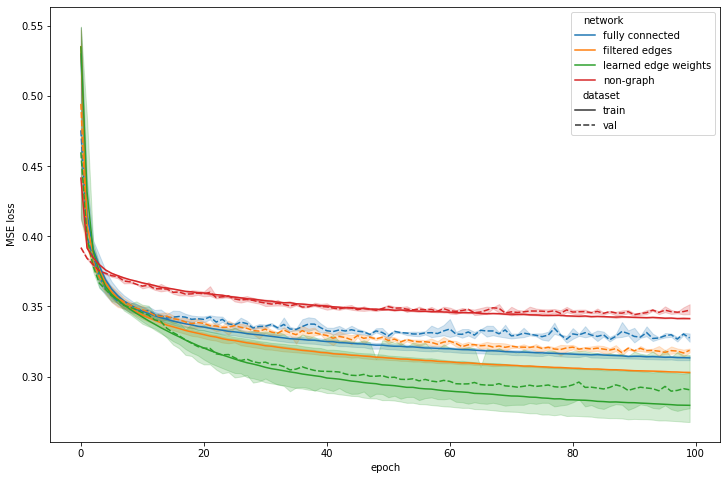

In [7]:
df = pd.DataFrame({
    'epoch': np.tile(np.arange(100),24),
    'MSE loss': np.concatenate((train_loss_list.flatten(), val_loss_list.flatten())),
    'network': np.array((["fully connected"]*(100) + ["filtered edges"]*(100) + ["learned edge weights"]*(100) + ["non-graph"]*(100))*6),
    'dataset': np.array(["train"]*(100*12) + ["val"]*(100*12))})
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.lineplot(ax=ax, data=df, x="epoch", y="MSE loss", hue="network", style="dataset")
plt.show()

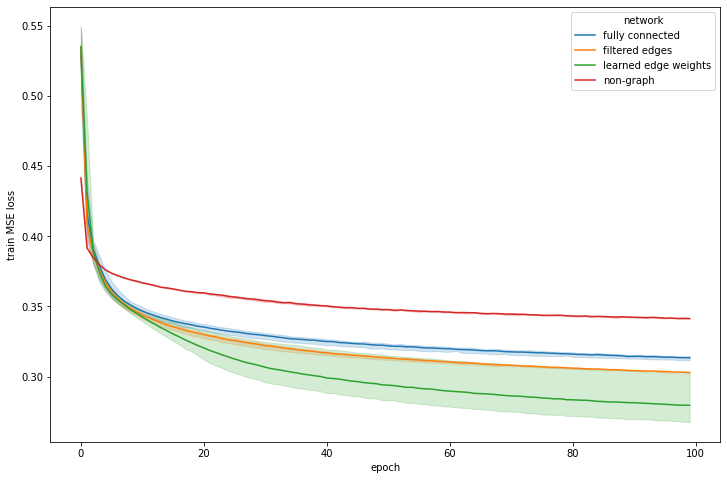

In [8]:
df = pd.DataFrame({
    'epoch': np.tile(np.arange(100),12),
    'train MSE loss': train_loss_list.flatten(),
    'network': np.array((["fully connected"]*(100) + ["filtered edges"]*(100) + ["learned edge weights"]*(100) + ["non-graph"]*(100))*3),
    'dataset': np.array(["train"]*(100*12))})
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.lineplot(ax=ax, data=df, x="epoch", y="train MSE loss", hue="network")
plt.show()

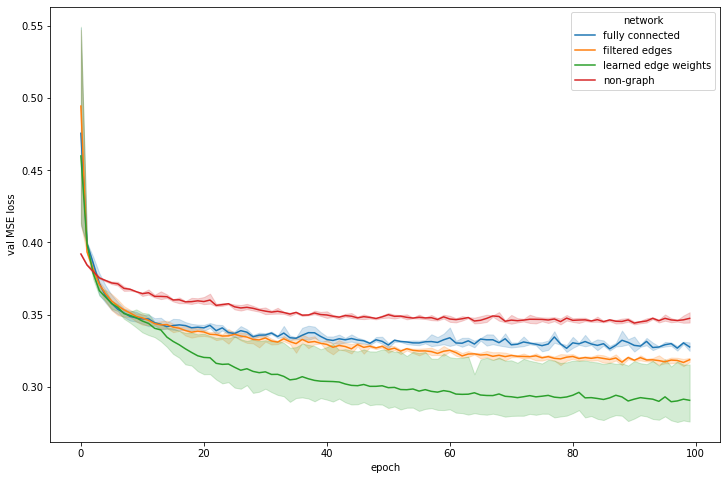

In [9]:
df = pd.DataFrame({
    'epoch': np.tile(np.arange(100),12),
    'val MSE loss': val_loss_list.flatten(),
    'network': np.array((["fully connected"]*(100) + ["filtered edges"]*(100) + ["learned edge weights"]*(100) + ["non-graph"]*(100))*3),
    'dataset': np.array(["val"]*(100*12))})
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.lineplot(ax=ax, data=df, x="epoch", y="val MSE loss", hue="network")
plt.show()

In [158]:
val_loss_list[2::4,-1]

array([0.28046, 0.31539, 0.27583])

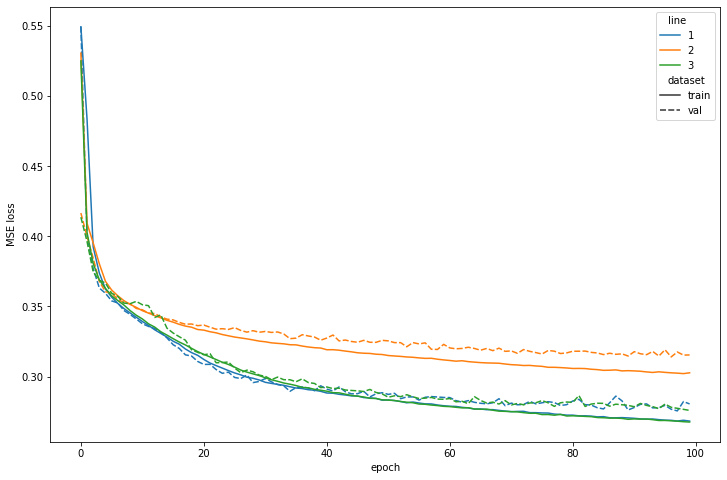

In [163]:
df = pd.DataFrame({
    'epoch': np.tile(np.arange(100),6),
    'MSE loss': np.concatenate((train_loss_list[2::4].flatten(), val_loss_list[2::4].flatten())),
    'network': np.array((["learned edge weights"]*(100))*6),
    'dataset': np.array(["train"]*(100*3) + ["val"]*(100*3)),
    'line': np.array((["1"]*(100) + ["2"]*(100) + ["3"]*(100))*2)})
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.lineplot(ax=ax, data=df, x="epoch", y="MSE loss", hue="line", style="dataset")
plt.show()

# Same with 6 fish

In [ ]:
fish_models.raw_data("pascal_6fish_couzin") 

## Load Checkpoint

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Edgeweight_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                               conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
PATH = f"pascal6_variation_{0}_learned.pt"
epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)

model.eval()

Edgeweight_SwarmNet(
  (encoder1): Conv1d(3, 9, kernel_size=(3,), stride=(2,))
  (encoder2): Conv1d(9, 1, kernel_size=(3,), stride=(2,))
  (edge_weighter1): Linear(in_features=39, out_features=128, bias=True)
  (edge_weighter2): Linear(in_features=128, out_features=1, bias=True)
  (gconv1): GraphConv(39, 128)
  (linears): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Linear(in_features=128, out_features=128, bias=True)
  )
  (predictor): Linear(in_features=128, out_features=1, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
)

# Build Fish Model from Torch Model

In [6]:
from matplotlib import animation
from IPython.display import HTML

In [19]:
# from importlib import reload
# import SwarmNet
# reload(SwarmNet)
# from SwarmNet import CouzinModel

In [6]:
model.eval()
model.to("cpu")
tracks, edge_weight_list = [], []
for i in range(4):
    raymodel = CouzinModel(model=model, raycast=raycast, view_width=150, save_edge_weights=True)
    generator = fish_models.TrackGenerator([raymodel], world_size=[100,100], frequency=10)
    track = generator.create_track(n_guppies=6, trackset_len=199)
    tracks.append(track)
    edge_weight_list.append(np.array(raymodel.edge_weights[0]))

100%|████████████████████████████████████████| 199/199 [00:07<00:00, 28.18it/s]


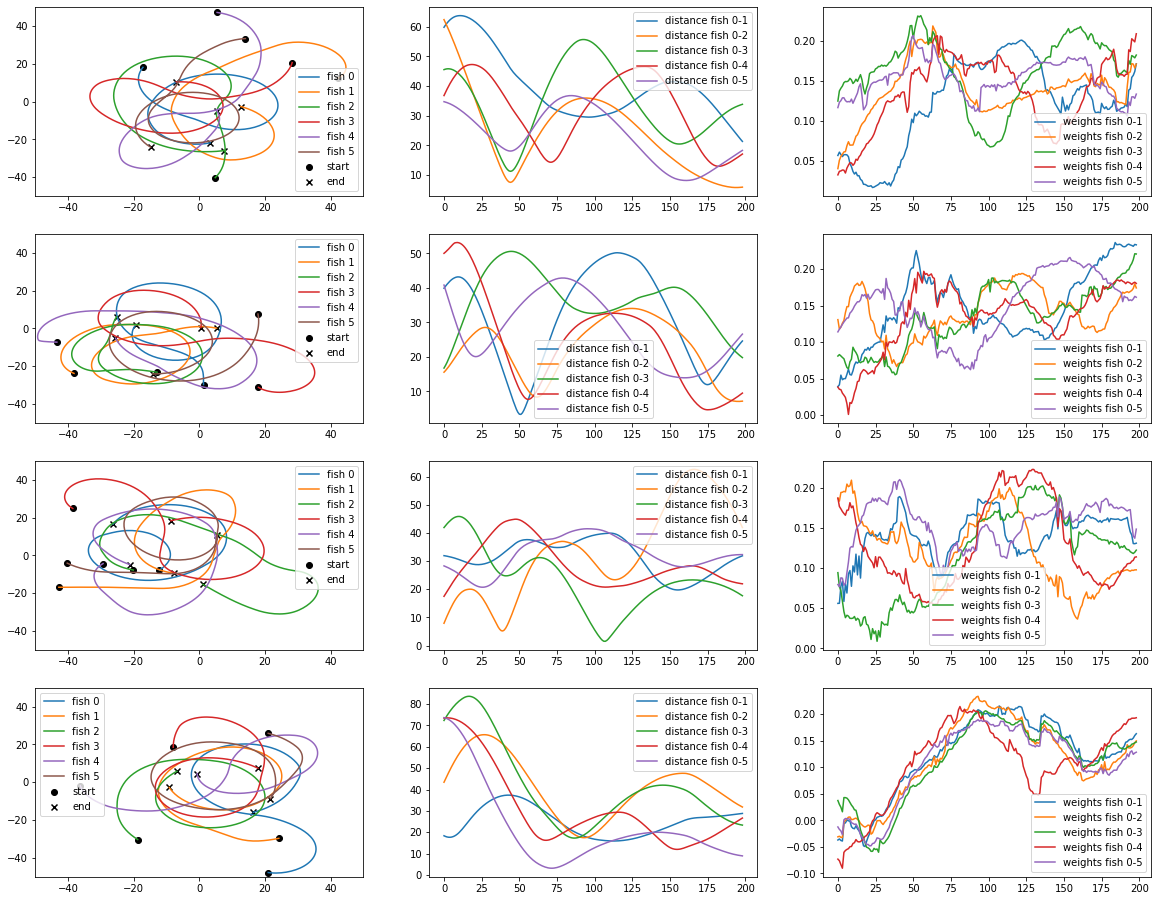

In [37]:

fig, axs = plt.subplots(4,3, figsize=(20,16))
for i in range(4):
    track = tracks[i]
    edge_w = edge_weight_list[i]
    for j in range(6):
        axs[i, 0].plot(track[j, :, 0], track[j, :, 1], label=f"fish {j}")
    for k in range(1,6):
        arr = np.linalg.norm(np.array(track[0, :, :2])-np.array([track[k, :, :2]]), axis=2)
        axs[i, 1].plot(arr.squeeze(), label=f"distance fish 0-{k}")
        axs[i, 2].plot(edge_w[:, k-1], label=f"weights fish 0-{k}")
    axs[i, 0].scatter(track[:, 0, 0], track[:, 0, 1], label="start", color="black", marker="o")
    axs[i, 0].scatter(track[:, -1, 0], track[:, -1, 1], label="end", color="black", marker="x")
    axs[i, 0].set_xlim([-50,50])
    axs[i, 0].set_ylim([-50,50])
    axs[i, 0].legend()
    axs[i, 1].legend()
    axs[i, 2].legend()
plt.show()

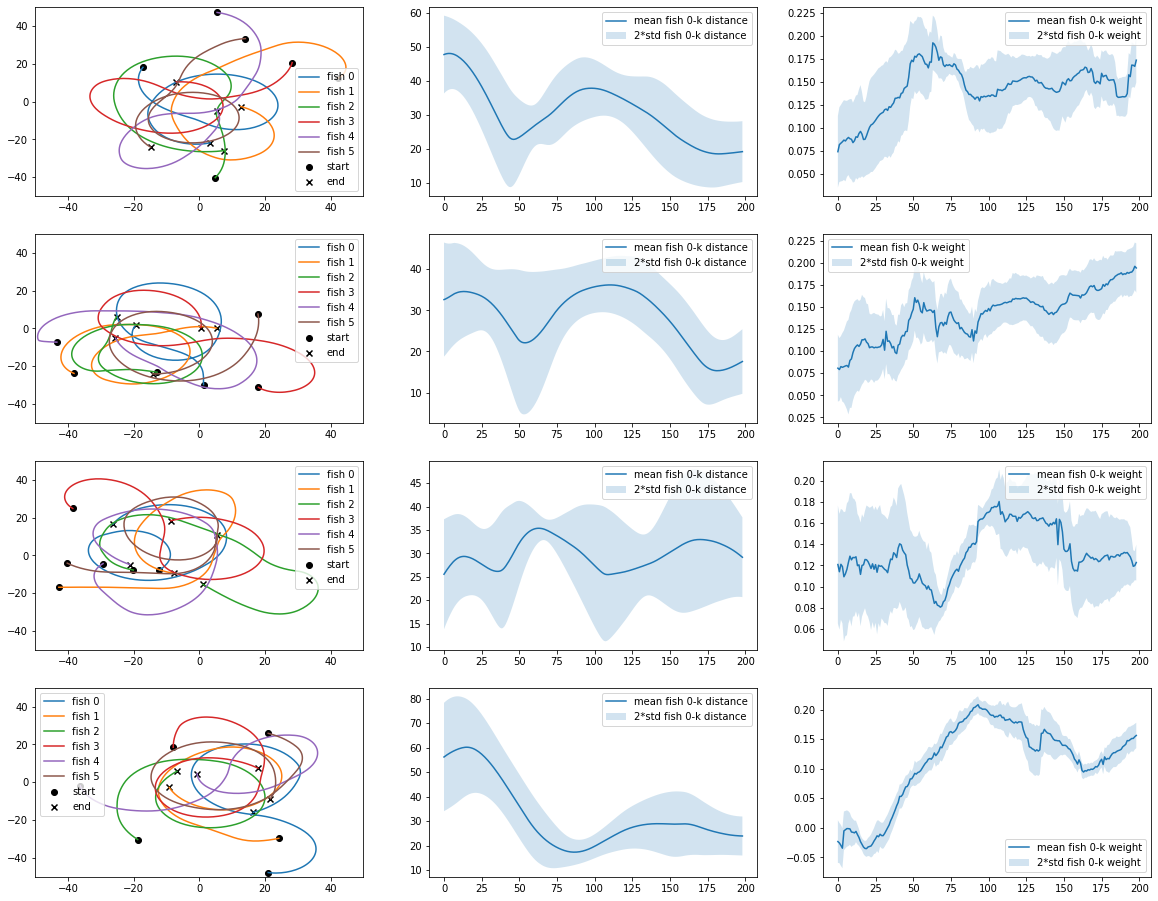

In [55]:

fig, axs = plt.subplots(4,3, figsize=(20,16))
for i in range(4):
    track = tracks[i]
    edge_w = edge_weight_list[i]
    for j in range(6):
        axs[i, 0].plot(track[j, :, 0], track[j, :, 1], label=f"fish {j}")
    dist = np.array([np.linalg.norm(np.array(track[0, :, :2])-np.array([track[k, :, :2]]), axis=2).squeeze() for k in range(1,6)])
    weigh = np.array([edge_w[:, k-1] for k in range(1,6)])
    axs[i, 1].plot(np.mean(dist, axis=0), label=f"mean fish 0-k distance")
    axs[i, 1].fill_between(np.arange(dist.shape[-1]), np.mean(dist, axis=0) - np.std(dist, axis=0), np.mean(dist, axis=0) + np.std(dist, axis=0),
                           alpha=0.2, label=f"2*std fish 0-k distance")
    axs[i, 2].plot(np.mean(weigh, axis=0), label=f"mean fish 0-k weight")
    axs[i, 2].fill_between(np.arange(weigh.shape[-1]), np.mean(weigh, axis=0) - np.std(weigh, axis=0), np.mean(weigh, axis=0) + np.std(weigh, axis=0),
                           alpha=0.2, label=f"2*std fish 0-k weight")
    axs[i, 0].scatter(track[:, 0, 0], track[:, 0, 1], label="start", color="black", marker="o")
    axs[i, 0].scatter(track[:, -1, 0], track[:, -1, 1], label="end", color="black", marker="x")
    axs[i, 0].set_xlim([-50,50])
    axs[i, 0].set_ylim([-50,50])
    axs[i, 0].legend()
    axs[i, 1].legend()
    axs[i, 2].legend()
plt.show()

In [7]:
model.eval()
model.to("cpu")
tracks, edge_weight_list = [], []
for i in range(50):
    raymodel = CouzinModel(model=model, raycast=raycast, view_width=150, save_edge_weights=True)
    generator = fish_models.TrackGenerator([raymodel], world_size=[100,100], frequency=10)
    track = generator.create_track(n_guppies=6, trackset_len=199)
    tracks.append(track)
    edge_weight_list.append(np.array(raymodel.edge_weights[0]))

100%|████████████████████████████████████████| 199/199 [00:07<00:00, 26.32it/s]


In [9]:
import scipy

In [10]:
euclidean_points, edge_w_points = [], []
for track in tracks:
    for i in range(6):
        for j in range(6):
            if i != j:
                euclidean_points.append(np.diag(scipy.spatial.distance.cdist(track[i, :, :2], track[j, :, :2])))
for edge_w in edge_weight_list:
    for i in range(6):
        for j in range(6):
            if i < j:
                edge_w_points.append(edge_w[:, (i*5)+j-1])
            elif i > j:
                edge_w_points.append(edge_w[:, (i*5)+j])
euclidean_points, edge_w_points = np.concatenate(euclidean_points), np.concatenate(edge_w_points)
euclidean_points.shape, edge_w_points.shape

((298500,), (298500,))

In [11]:
wall_dists = []
for track in tracks:
    for i in range(6):
        for j in range(6):
            if i != j:
                p1, p2 = np.array([0,0]), np.array([0,100])
                p3 = track[i, :, :2] +50
                d1 = np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
                p1, p2 = np.array([0,100]), np.array([100,100])
                d2 = np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
                p1, p2 = np.array([100,100]), np.array([100,0])
                d3 = np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
                p1, p2 = np.array([100,0]), np.array([0,0])
                d4 = np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
                wall_dists.append(np.min(np.abs(np.array([d1,d2,d3,d4])),axis = 0))
wall_dists = np.concatenate(wall_dists)
wall_dists.shape

(298500,)

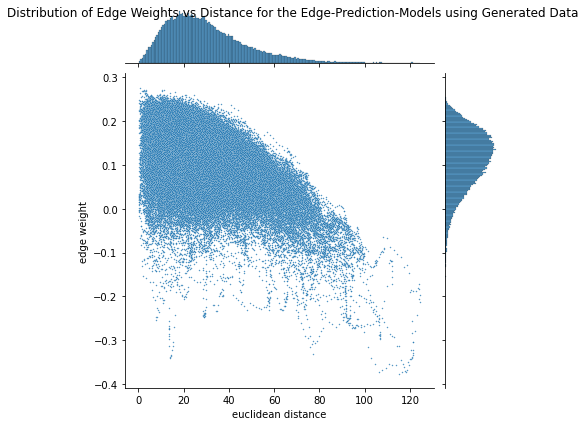

In [13]:
df = pd.DataFrame({
    'euclidean distance': euclidean_points,
    'edge weight': edge_w_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
p = sns.jointplot(data=df, y="edge weight", x="euclidean distance", s=2, alpha=0.5)
p.fig.suptitle("Distribution of Edge Weights vs Distance for the Edge-Prediction-Models using Generated Data")
# p.fig.get_axes()[0].legend().set_visible(False)
# p.fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# p.ax_marg_y.set_ylim(-1.5,1.5)
# p.ax_marg_x.set_xlim(0,100)
plt.show()

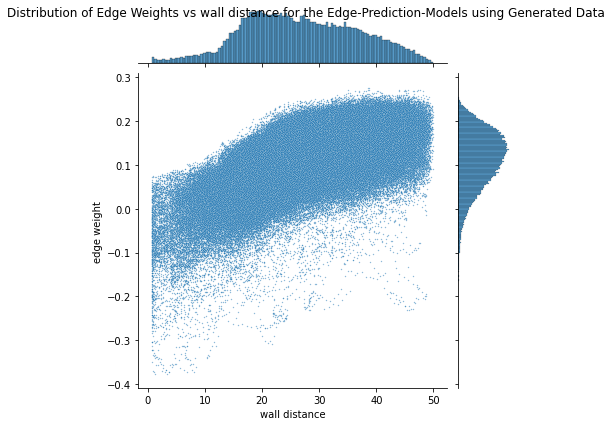

In [14]:
df = pd.DataFrame({
    'wall distance': wall_dists,
    'edge weight': edge_w_points,
    'zone': ['zone of repulsion' if x < 10 else 'zone of orientation' if x < 20 else 'zone of attraction' if x < 40 else 'no zone' for x in euclidean_points]})
p = sns.jointplot(data=df, y="edge weight", x="wall distance", s=2, alpha=0.5)
p.fig.suptitle("Distribution of Edge Weights vs wall distance for the Edge-Prediction-Models using Generated Data")
# p.fig.get_axes()[0].legend().set_visible(False)
# p.fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# p.ax_marg_y.set_ylim(-1.5,1.5)
# p.ax_marg_x.set_xlim(0,100)
plt.show()

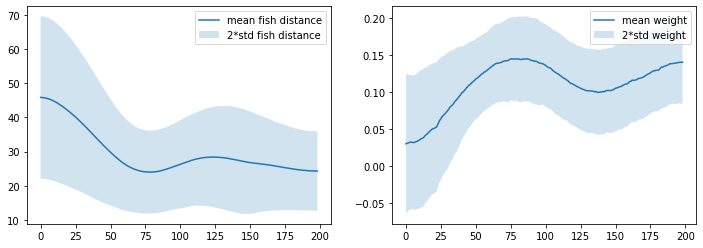

In [15]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
d_list = []
for track in tracks:
    for i in range(6):
        for j in range(i+1,6):
            d_list.append(np.linalg.norm(np.array(track[i, :, :2])-np.array([track[j, :, :2]]), axis=2).squeeze())
d_list = np.array(d_list)
a = np.mean(d_list, axis=0)
b = np.std(d_list, axis=-0)
axs[0].plot(a, label=f"mean fish distance")
axs[0].fill_between(np.arange(a.shape[-1]), a - b, a + b, alpha=0.2, label=f"2*std fish distance")
a = np.mean(np.concatenate(edge_weight_list, axis=-1), axis=-1)
b = np.std(np.concatenate(edge_weight_list, axis=-1), axis=-1)
axs[1].plot(a, label=f"mean weight")
axs[1].fill_between(np.arange(a.shape[-1]), a - b, a + b, alpha=0.2, label=f"2*std weight")
axs[0].legend()
axs[1].legend()
plt.show()

In [16]:
from tqdm import tqdm

In [26]:
# cross corr calculations distances
arr = []
arr2 = []
n = 200
for i in tqdm(range(n)):
    brr = []
    brr2 = []
    for j in range(n):
        if i != j:
            crr = []
            crr2 = []
            for k in range(-10, 10):
                crr.append(pd.Series(d_list[i]).corr(pd.Series(d_list[j]).shift(k)))
                crr2.append(k)
            brr.append(crr)
            brr2.append(crr2)
    arr.append(brr)
    arr2.append(brr2)
arr = np.array(arr)
arr2 = np.array(arr2)

100%|████████████████████████████████████████| 200/200 [10:42<00:00,  3.21s/it]


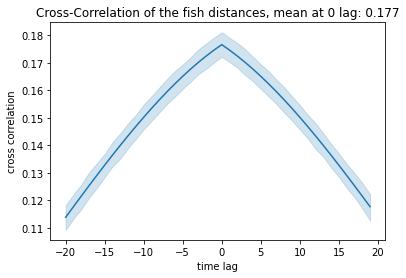

In [27]:
df = pd.DataFrame({
    'cross correlation': arr.flatten(),
    'time lag': arr2.flatten()})
p = sns.lineplot(data=df, y="cross correlation", x="time lag")
plt.title(f"Cross-Correlation of the fish distances, mean at 0 lag: {np.mean(arr[arr2 == 0]):.3f}")
plt.show()

In [24]:
np.concatenate(edge_weight_list, axis=-1).shape

(199, 1500)

In [41]:
# cross corr calculations
arr = []
arr2 = []
abc = np.concatenate(edge_weight_list, axis=-1)
for i in tqdm(range(100)):
    brr = []
    brr2 = []
    for j in range(100):
        if i != j:
            crr = []
            crr2 = []
            for k in range(-10, 10):
                crr.append(pd.Series(abc[:,i]).corr(pd.Series(abc[:,j]).shift(k)))
                crr2.append(k)
        brr.append(crr)
        brr2.append(crr2)
    arr.append(brr)
    arr2.append(brr2)
arr = np.array(arr)
arr2 = np.array(arr2)

100%|████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


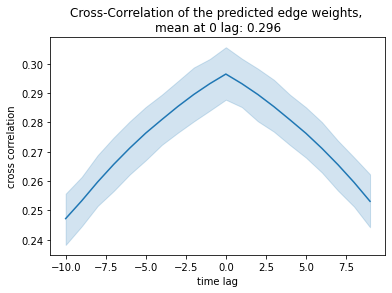

In [42]:
df = pd.DataFrame({
    'cross correlation': arr.flatten(),
    'time lag': arr2.flatten()})
p = sns.lineplot(data=df, y="cross correlation", x="time lag")
plt.title(f"Cross-Correlation of the predicted edge weights, \nmean at 0 lag: {np.mean(arr[arr2 == 0]):.3f}")
plt.show()

In [7]:
model.eval()
model.to("cpu")
raymodel = CouzinModel(model=model, raycast=raycast, view_width=150)
generator = fish_models.TrackGenerator([raymodel], world_size=[100,100], frequency=10)

In [8]:
track = generator.create_track(n_guppies=6, trackset_len=199)
track.shape

100%|████████████████████████████████████████| 199/199 [00:07<00:00, 25.20it/s]


(6, 199, 3)

In [191]:
np.array(raymodel.edge_weights[:6], dtype=np.float32).shape

(6, 199, 30)

In [178]:
num_nodes = 6
list2 = []
list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
for k in range(num_nodes):
    list2.append(np.concatenate((np.arange(num_nodes)[:k], np.arange(num_nodes)[k+1:])))
list2 = np.concatenate(list2)
edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)

In [179]:
raymodel.edge_weights[0][0][edge_index[0]==0]

array([ 0.1828 , -0.05644,  0.17351,  0.17785,  0.09565], dtype=float32)

In [180]:
track.shape

(6, 199, 3)

In [181]:
distances = []
for lnum in range(5):
    arr = np.linalg.norm(np.array(track[0, :, :2])-np.array([track[lnum+1, :, :2]]), axis=2)
    distances.append(arr)

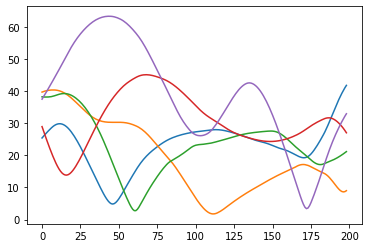

In [182]:
for i in range(5):
    plt.plot(np.array(distances).squeeze()[i])
plt.show()

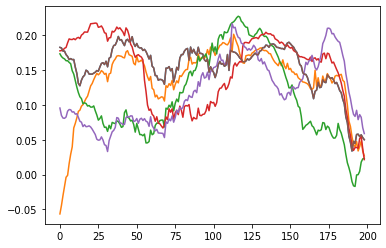

In [183]:
plt.plot(np.array(raymodel.edge_weights[:6], dtype=np.float32)[0, :, :6])
plt.show()

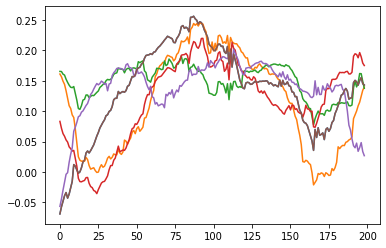

In [184]:
plt.plot(np.array(raymodel.edge_weights[:6], dtype=np.float32)[0, :, 6:12])
plt.show()

In [185]:
raymodel.edge_weights[0][1][edge_index[0]==1]

array([ 0.18192, -0.05724,  0.15667,  0.16522,  0.07198], dtype=float32)

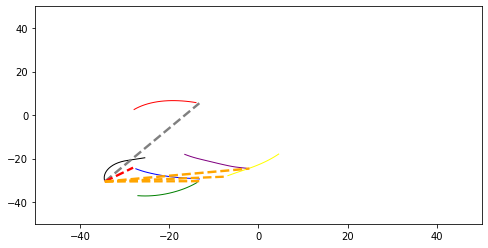

In [186]:
fig = plt.figure(figsize=(8,4))
ax = plt.axes(xlim=(-50, 50), ylim=(-50, 50))
line, = ax.plot([], [], lw=2)

plotcols = ["black", "red", "blue", "green", "yellow", "purple"]

lines = []
for index in range(6):
    lobj = ax.plot([],[],lw=1,color=plotcols[index])[0]
    lines.append(lobj)
for index in range(5):
    lobj = ax.plot([],[],lw=1,color="grey", linestyle="--")[0]
    lines.append(lobj)

def init():
    for line in lines:
        line.set_data([],[])
    return lines

def animate(i):
    for lnum, line in enumerate(lines[:6]):
        min_i = (i-20) if i > 20 else 0
        line.set_data(track[lnum, min_i:i, 0], track[lnum, min_i:i, 1])
    for lnum, line in enumerate(lines[6:]):
        norm_dist = np.linalg.norm(np.array([track[0, i, 0], track[0, i, 1]])-np.array([track[lnum+1, i, 0], track[lnum+1, i, 1]]))
        if norm_dist > 40:
            line.set_data([track[0, i, 0],track[lnum+1, i, 0]], [track[0, i, 1], track[lnum+1, i, 1]])
            plt.setp(line, color="grey", linewidth=(np.array(raymodel.edge_weights[:6], dtype=np.float32)[0, i, lnum]+1.5)**2)
        elif norm_dist > 20:
            line.set_data([track[0, i, 0],track[lnum+1, i, 0]], [track[0, i, 1], track[lnum+1, i, 1]])
            plt.setp(line, color="orange", linewidth=(np.array(raymodel.edge_weights[:6], dtype=np.float32)[0, i, lnum]+1.5)**2)
        elif norm_dist > 10:
            line.set_data([track[0, i, 0],track[lnum+1, i, 0]], [track[0, i, 1], track[lnum+1, i, 1]])
            plt.setp(line, color="green", linewidth=(np.array(raymodel.edge_weights[:6], dtype=np.float32)[0, i, lnum]+1.5)**2)
        else:
            line.set_data([track[0, i, 0],track[lnum+1, i, 0]], [track[0, i, 1], track[lnum+1, i, 1]])
            plt.setp(line, color="red", linewidth=(np.array(raymodel.edge_weights[:6], dtype=np.float32)[0, i, lnum]+1.5)**2)
    return lines

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=199, interval=1, blit=True)

display(HTML(anim.to_jshtml()))